In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

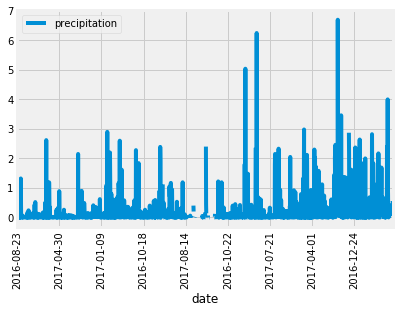

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#print(max_Date)


#Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
precipitation = session.query(*sel).filter(Measurement.date >= '2016-08-23').all()


#precipitation_12mons = engine.execute("select date, prcp from Measurement where date >'2016-08-24'and date <='2017-08-23'").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_db = pd.DataFrame(precipitation, columns = ['date','precipitation'])
precipitation_db.set_index(precipitation_db['date'],inplace= True)


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_db.plot(rot = 90)
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_db.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station = session.query (Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
#station = engine.execute('select station, count(id) from Measurement group by station order by count(id) desc').fetchall()
station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
pd.DataFrame(most_active_station,columns=['min','max','avg'])

,min,max,avg
0,54.0,85.0,71.663781


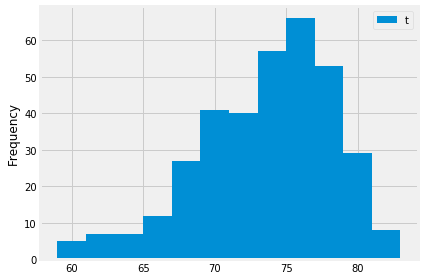

In [15]:
# Choose the station with the highest number of temperature observations.
highest_temp_station = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
highest_temp_station

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temp_12mons = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
clean_high_temp_12mons = list(np.ravel(high_temp_12mons))

# bin = [0,60,65,70,75,80,90]
plt.hist(clean_high_temp_12mons, bins =12)
plt.ylabel('Frequency')
plt.legend('tobs')
plt.tight_layout()
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    #"""TMIN, TAVG, and TMAX for a list of dates.
#     tmin = session.query(func.min(Measurement.tobs)).filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
#     tavg = session.query(func.avg(Measurement.tobs)).filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
#     tmax = session.query(func.max(Measurement.tobs)).filter(Measurement.date > start_date).filter(Measurement.date < end_date).all()
    
    #Args:
        #start_date (string): A date string in the format %Y-%m-%d
        #end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
    #"""
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps_range = list(np.ravel(calc_temps('2016-06-06','2016-06-20')))
temps_range

[69.0, 75.43877551020408, 81.0]

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

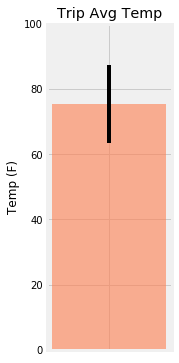

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
variance = temps_range[2]-temps_range[0]
plt.figure(figsize=(2,6))
plt.bar('',temps_range[1],yerr = variance,color='coral',alpha = 0.6)
plt.ylabel('Temp (F)')
plt.ylim(0,100)
plt.title("Trip Avg Temp")
plt.grid

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_rainfall(start_date, end_date):
    
    return session.query(Measurement.station, func.sum(Measurement.prcp)).\
                filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
                group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()


rainfall = (calc_rainfall('2012-02-28', '2012-03-05'))     
rainfall_db = pd.DataFrame(rainfall,columns = ('station','total_rainfall'))
rainfall_db                                                   

,station,total_rainfall
0,USC00519281,11.08
1,USC00516128,10.32
2,USC00513117,5.79
3,USC00518838,3.84
4,USC00519523,2.92
5,USC00519397,1.18
6,USC00511918,0.76
7,USC00514830,0.03
8,USC00517948,0.00


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
print(daily_normals("03-09"))

[(57.0, 68.56140350877193, 75.0)]


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# from datetime import date, timedelta
# Use the start and end date to create a range of dates
date_range = pd.date_range('03-02-2019','03-09-2019',freq = 'D')

# Stip off the year and save a list of %m-%d strings
date_range = date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for row in date_range:
        normals.append(*daily_normals(row))

normals


[(61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_db = pd.DataFrame(normals, columns = ['min', 'avg','max'])
date_range_db = pd.DataFrame(date_range)
normals_db['date'] = date_range_db
normals_db.set_index('date')

,min,avg,max
date,,,
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


Text(0.5, 0, 'date')

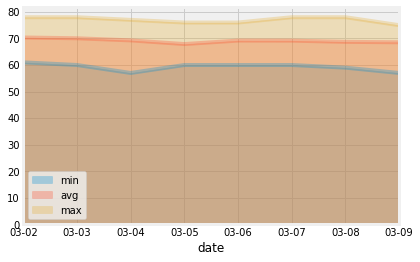

In [38]:
# Plot the daily normals as an area plot with `stacked=False`
# tmin = normals_db['min']
# tmax = normals_db['max']
# tavg = normals_db['avg']
ax = normals_db.plot.area(x = 'date',stacked = False,alpha = 0.3)
plt.xlabel('date')
